In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
%matplotlib inline

## IMDB data cleaning

In [2]:
# Read in imdb CSVs

imdb_name_basics_df = pd.read_csv(f'zippedData/imdb.name.basics.csv.gz', encoding='utf-8')
imdb_title_basics_df = pd.read_csv(f'zippedData/imdb.title.basics.csv.gz', encoding='utf-8')
imdb_title_crew_df = pd.read_csv(f'zippedData/imdb.title.crew.csv.gz', encoding='utf-8')
imdb_title_principals_df = pd.read_csv(f'zippedData/imdb.title.principals.csv.gz', encoding='utf-8')
imdb_title_ratings_df = pd.read_csv(f'zippedData/imdb.title.ratings.csv.gz', encoding='utf-8')

In [3]:
# Function to split multiple results into lists, skipping NaN values for cleaning later
def sepc_nonu(sodf):
    if pd.isna(sodf):
        return sodf
    try:
        return str(sodf).split(',')
    except:
        return sodf

In [4]:
# split multiple values into list of values for names
imdb_name_basics_df[['primary_profession','known_for_titles']] = \
imdb_name_basics_df[['primary_profession','known_for_titles']].applymap(sepc_nonu)

In [5]:
# split multiple values into list of values for genres
imdb_title_basics_df['genres'] = imdb_title_basics_df['genres'].map(sepc_nonu)

In [6]:
# split multiple values into list of values for names
imdb_title_crew_df[['directors','writers']] = imdb_title_crew_df[['directors','writers']].applymap(sepc_nonu)

Now we have some tables with accessible id numbers.

We should figure out how to organize the table now. Since we're looking for revenue/ROI, the fundamental organizer should be the title, which we have money info for. Therefore, the leftmost data should be title information.
 - imdb_title_basics

Next should be ratings info from IMDB, for ease. We'll join the ratings to the basics.
 - imdb_title_ratings

We can ignore the following dataframe, as it's just a list of foreign translations of movies we already have American English titles for:
 - imdb_title_akas

In [7]:
imdb_title_basicsratings_df = imdb_title_basics_df.merge(imdb_title_ratings_df, how='left', on='tconst')

Now we need to find a way to access cast/crew info, should we want to know that information downstream.  I think the best way to do this is to use tconst to merge
 - imdb_title_crew
 - imdb_title_principals

with
 - imdb_title_basicsratings

There are identifying keys in 
 - imdb_name_basics
 
that we can later use to get the names using 'nconst' (and other info, like if they've died).

In [8]:
imdb_comp = imdb_title_basicsratings_df.merge(imdb_title_crew_df, how='left', on='tconst')

In [9]:
# 'job' and 'characters' provide unnecessary information for our purposes
imdb_title_principals_df = imdb_title_principals_df.drop(['job','characters'],axis=1)

In [10]:
# group by movie and category, make into a list of name ids
imdb_princ_group = imdb_title_principals_df.groupby(['tconst','category'])['nconst'].apply(list)

In [14]:
# reset the index
imdb_princ_group = imdb_princ_group.reset_index()

In [15]:
# pivot the table to have tconst as the index, columns with the 'category' job titles, and
# values of the lists of name ids
imdb_princ_grppiv = imdb_princ_group.pivot(index='tconst',columns='category',values='nconst')

In [16]:
# change column names to prevent conflicts with downstream merging
imdb_princ_grppiv.rename(mapper={'director':'director_pr', 'writer':'writer_pr'}, axis=1, inplace=True)

Alright so now we have
 - imdb_comp
with title info and the director/writer column. Let's add the principal columns from
 - imdb_princ_grppiv

In [17]:
imdb_comp = imdb_comp.merge(imdb_princ_grppiv, how='left', on='tconst')

In [18]:
# Make a new directory to store the clean files

!mkdir cleanIMDB

mkdir: cleanIMDB: File exists


In [19]:
# Export clean IMDB files to CSV

imdb_comp.to_csv('cleanIMDB/imdb_comp.csv')
imdb_name_basics_df.to_csv('cleanIMDB/imdb_namekey.csv')

## Data cleaning for The Numbers and Data.World Twitter Reviews

In [20]:
# Reading in compressed csv

tn_budgets = pd.read_csv('./zippedData/tn.movie_budgets.csv.gz')

In [21]:
# Global variables

first_year = 2010
review_count_threshold = 50

In [22]:
# Reading in .dat files

dataworld_movies = pd.read_csv('movies.dat', sep='::', names=['movie_id', 'name/year', 'genre'])
dataworld_reviews = pd.read_csv('ratings.dat', sep='::', names=['user_id', 'movie_id', 'rating', 'rating_timestamp'])

<ipython-input-22-4538fe068736>:3: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  dataworld_movies = pd.read_csv('movies.dat', sep='::', names=['movie_id', 'name/year', 'genre'])
<ipython-input-22-4538fe068736>:4: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  dataworld_reviews = pd.read_csv('ratings.dat', sep='::', names=['user_id', 'movie_id', 'rating', 'rating_timestamp'])


## The Numbers (TN) budgets

### Data Cleaning Summary

- Converted all budget info (revenue, costs) to integers
- Calculated % and dollars of ROI. ROI calc is (worldwide gross - budget) / budget
- Split release_date into separate month and year columns
- Filtered for only movies after 2010. Rationale is that we are trying to make relevant recommendations to a newly launched studio. Trends prior to 2010 probably don't have as much relevance. There's an argument to be made that we should be filtering on even more recent data.
- Removed movies with 0 worldwide_gross. Believe this is a combinatoin of (1) data error (confirmed released movies with revenue have 0 in this column) or (2) movies recently made that haven't been released yet.
- Adjusted revenue / expenses for inflation (after confirming via Google searches that it wasn't already adjusted).
- Decided to leave the 84 movies that were duplicated (given such a small part of the sample)

source: https://www.usinflationcalculator.com

In [23]:
# Convert string columns to int

rev_cols = ['production_budget', 'domestic_gross', 'worldwide_gross']

tn_budgets.loc[:,rev_cols] = tn_budgets.loc[:,rev_cols].applymap(lambda x: int(x.replace('$', '').replace(',','')))

In [24]:
# Calculate ROI ($ and %)

tn_budgets['ROI_percent'] = (tn_budgets['worldwide_gross'] - tn_budgets['production_budget']) / tn_budgets['production_budget']
tn_budgets['ROI_usd'] = tn_budgets['worldwide_gross'] - tn_budgets['production_budget']

In [25]:
# Parse release date for year / months

tn_budgets['year'] = tn_budgets['release_date'].apply(lambda x: int(x[-4:]))
tn_budgets['month'] = tn_budgets['release_date'].apply(lambda x: x[:3])

month_full = {'Jan': 'January', 'Feb': 'February', 'Mar': 'March', 'Apr': 'April', 'Jun': 'June',
             'Jul': 'July', 'Aug': 'August', 'Sep': 'September', 'Oct': 'October', 'Nov': 'November',
              'Dec': 'December'}

tn_budgets['month'] = tn_budgets['month'].replace(month_full)

In [26]:
# Filter for only recent releases

tn_budgets_recent = tn_budgets[tn_budgets['year'] >= 1990]

In [27]:
# Filter out movies with 0 world_wide gross

tn_budgets_recent = tn_budgets_recent[tn_budgets_recent['worldwide_gross'] != 0]

In [28]:
# Adjust revenue #'s for inflation

years = list(range(1990,2022))

inflation = [2.09, 2.00, 1.95, 1.89, 1.84, 1.79, 1.74, 1.70, 1.67, 1.64, 1.59, 1.54, 1.52, 1.48, 1.45, 1.40, 1.35, 
1.32, 1.27, 1.27, 1.25, 1.21, 1.19, 1.17, 1.15, 1.15, 1.14, 1.11, 1.09, 1.07, 1.05, 1.00]

inflation_dict = dict(zip(years,inflation))

In [29]:
tn_budgets_recent['inflation'] = tn_budgets_recent['year'].apply(lambda x: inflation_dict[x])

In [30]:
# Convert all $ to 2021

tn_budgets_recent['worldwide_gross_inf'] = tn_budgets_recent.loc[:,'worldwide_gross'] * tn_budgets_recent.loc[:,'inflation']
tn_budgets_recent['domestic_gross_inf'] = tn_budgets_recent.loc[:,'domestic_gross'] * tn_budgets_recent.loc[:,'inflation']
tn_budgets_recent['production_budget_inf'] = tn_budgets_recent.loc[:,'production_budget'] * tn_budgets_recent.loc[:,'inflation']

In [31]:
tn_budgets_recent['ROI_USD_inf'] = tn_budgets_recent['worldwide_gross_inf'] - tn_budgets_recent['production_budget_inf']

In [32]:
# Filter for only recent releases

tn_budgets_recent = tn_budgets_recent[tn_budgets_recent['year'] >= first_year]

In [33]:
tn_budgets_clean = tn_budgets_recent.copy()

## Dataworld movies / reviews

- Cleaning: Separated Name/year from the same column
- Separated genre into a list
- Joined the databases together
- Drop the few NaN values from genre. Only 80 out of 38K
- For the reviews. Group by movie ID and aggregate average review and count
- Set threshold for 50 reviews to be included in the dataset

In [34]:
# Create a copy

dataworld_clean = dataworld_movies.copy()

In [35]:
# Separate out name and year into separate columns

dataworld_clean['year'] = dataworld_clean.loc[:,'name/year'].apply(lambda x: int(x[-5:-1]))
dataworld_clean['name'] = dataworld_clean.loc[:,'name/year'].apply(lambda x: x[0:-7])

In [36]:
# Drop NAs

dataworld_clean.dropna(subset=['genre'], inplace=True)

In [37]:
# Separate out the different genres

dataworld_clean['genre_list'] = dataworld_clean.loc[:,'genre'].apply(lambda x: x.split('|'))
dataworld_clean['genre_length'] = dataworld_clean.loc[:,'genre_list'].apply(lambda x: len(x))

In [38]:
reviews_clean = dataworld_reviews.copy()
reviews_clean['rating2'] = reviews_clean.loc[:,'rating']

In [39]:
# Aggregate movies by avg review and review_count

new_cols = {'rating': 'avg_rating', 'rating2': 'rating_count'}
reviews_clean = reviews_clean.groupby('movie_id').agg({'rating':'mean', 'rating2':'count'}).rename(columns=new_cols)

In [40]:
# Join the two dataframes on movieID

dataworld_clean = dataworld_clean.merge(reviews_clean, on='movie_id', how='left')

In [41]:
# Filter for only movies made since 2000

dataworld_clean = dataworld_clean[dataworld_clean['year'] >= first_year]

In [42]:
# Filter for movies with at least 50 reviews

dataworld_clean = dataworld_clean[dataworld_clean['rating_count'] >= review_count_threshold]

In [43]:
# Final datasets to export to CSV

tn_budgets_clean.to_csv('theNumbers_clean.csv')
dataworld_clean.to_csv('twitter_reviews_clean.csv')

## Join profitability data to the clean IMDB file

In [44]:
# Read in cleaned CSVs

tn_df = pd.read_csv('theNumbers_clean.csv')
imdb_basics = pd.read_csv('./cleanIMDB/imdb_comp.csv')
twitter_reviews = pd.read_csv('twitter_reviews_clean.csv')

In [45]:
# Concatenate movie name and year together, creating a new column called 'concat'

tn_df['concat'] = tn_df['movie'] + tn_df['year'].apply(lambda x: str(x))
imdb_basics['concat'] = imdb_basics['primary_title'] + imdb_basics['start_year'].apply(lambda x: str(x))

In [46]:
# Join based on our new concatenated field

imdb_combined = imdb_basics.merge(tn_df, how='inner', on='concat')

In [47]:
# create a new column for ROI %, using gross & budget adjusted for inflation
imdb_combined['ROI%_inf'] = (imdb_combined['worldwide_gross_inf']-imdb_combined['production_budget_inf'])\
                             / imdb_combined['production_budget_inf'] * 100

In [48]:
imdb_combined.sort_values('ROI%_inf', ascending=False)

,Unnamed: 0_x,tconst,primary_title,original_title,start_year,runtime_minutes,genres,averagerating,numvotes,directors,...,ROI_percent,ROI_usd,year,month,inflation,worldwide_gross_inf,domestic_gross_inf,production_budget_inf,ROI_USD_inf,ROI%_inf
910,35625,tt2309260,The Gallows,The Gallows,2015,81.0,"['Horror', 'Mystery', 'Thriller']",4.2,17763.0,"['nm4000389', 'nm3951039']",...,415.564740,41556474,2015,July,1.15,4.790495e+07,2.617907e+07,115000.0,4.778995e+07,41556.474000
482,9487,tt1560985,The Devil Inside,The Devil Inside,2012,83.0,['Horror'],4.2,33522.0,['nm0068587'],...,100.759490,100759490,2012,January,1.19,1.210938e+08,6.338290e+07,1190000.0,1.199038e+08,10075.949000
466,8964,tt1536044,Paranormal Activity 2,Paranormal Activity 2,2010,91.0,['Horror'],5.7,93122.0,['nm0931095'],...,58.170677,174512032,2010,October,1.25,2.218900e+08,1.059411e+08,3750000.0,2.181400e+08,5817.067733
1318,87039,tt5052448,Get Out,Get Out,2017,104.0,"['Horror', 'Mystery', 'Thriller']",7.7,400474.0,['nm1443502'],...,50.073590,250367951,2017,February,1.11,2.834584e+08,1.954051e+08,5550000.0,2.779084e+08,5007.359020
1312,85930,tt4975722,Moonlight,Moonlight,2016,111.0,['Drama'],7.4,227964.0,['nm1503575'],...,42.497008,63745512,2016,October,1.14,7.437988e+07,3.175462e+07,1710000.0,7.266988e+07,4249.700800
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1098,60973,tt3523348,Destiny,Destiny,2014,105.0,"['Drama', 'Music', 'Romance']",7.8,36.0,['nm4154451'],...,-0.999400,-749550,2014,December,1.15,5.175000e+02,0.000000e+00,862500.0,-8.619825e+05,-99.940000
1097,55110,tt3231362,Destiny,Destiny,2014,NaN,"['Adventure', 'Comedy', 'Family']",8.4,25.0,['nm5932375'],...,-0.999400,-749550,2014,December,1.15,5.175000e+02,0.000000e+00,862500.0,-8.619825e+05,-99.940000
979,41677,tt2503954,Broken Horses,Broken Horses,2015,101.0,"['Action', 'Crime', 'Drama']",5.7,1957.0,['nm0006765'],...,-0.999769,-14996529,2015,September,1.15,3.991650e+03,0.000000e+00,17250000.0,-1.724601e+07,-99.976860
837,29832,tt2141739,Food Chains,Food Chains,2014,83.0,['Documentary'],7.2,328.0,['nm2515753'],...,-0.999807,-912824,2014,November,1.15,2.024000e+02,0.000000e+00,1049950.0,-1.049748e+06,-99.980723


In [49]:
imdb_sort = imdb_combined.sort_values('ROI%_inf',ascending=True)
imdb_sort = imdb_sort[:-2] # remove The Gallows (2015) and The Devil Inside (2012) because they are outliers
# only films that have grossed at least $100K worldwide: less than that could just be limited runs
imdb_sort = imdb_sort[imdb_sort['worldwide_gross_inf'] >= 100000] 

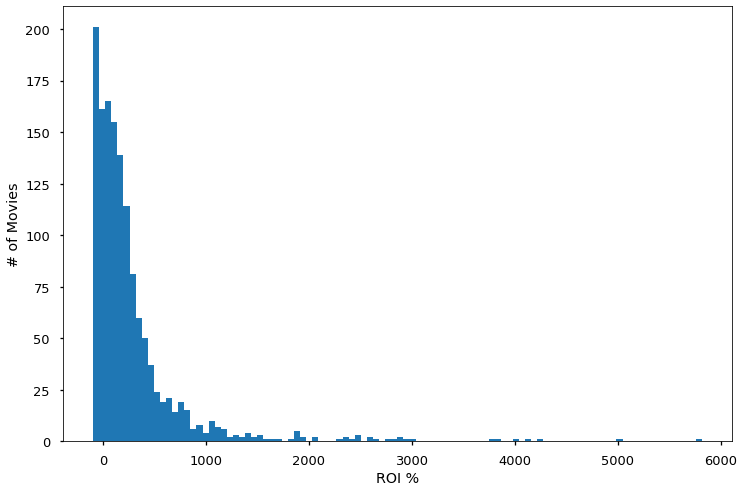

In [50]:
plt.style.use('seaborn-talk')
fig, ax = plt.subplots(figsize=[12,8])

ax.hist(imdb_sort['ROI%_inf'], bins=100)
ax.set_xlabel('ROI %')
ax.set_ylabel('# of Movies');

In [51]:
imdb_sort.to_csv('imdb_combined_prof.csv')